# **Regression Practice - Bike Sharing in Washington DC (자전거 수요 예측)**

* Source: https://www.kaggle.com/marklvl/bike-sharing-dataset

### **목적** 

자전거 대여 횟수를 예측하기 위해, 회귀(Regression) 분석을 하는 것이 이번 시간의 목표입니다.

### **특징**

2011년에서 2012년도 미국의 워싱턴 DC의 자전거 대여 공공데이터

자료에는 날짜, 날씨, 온도, 계절, 체감온도, 풍속, 자전거 대여 횟수 등이 시간별로 기록

### **Feature(속성) 설명**

`rides`의 각 열별로 나타내는 정보는 다음과 같습니다.

* `instant`: 기록번호
* `dteday`: 날짜
* `season`: 계절 (`1`:봄, `2`:여름, `3`:가을, `4`:겨울)
* `yr`: 연도 (`0`: 2011, `1`:2012)
* `mnth`: 달 (`1` ~ `12`)
* `hr`: 시간 (`0` ~ `23`)
* `holiday`: 휴일(`0`/`1`)
* `weekday`: 요일
* `workingday`: 평일(`0`/`1`)
* `weathersit`:
    * `1`: 맑거나 조금 흐림
    * `2`: 안개 및 흐림
    * `3`: 가벼운 눈, 비
    * `4`: 많은 비, 눈, 뇌우
* `temp`: `0`에서 `1`까지의 표준화된 섭씨 온도(최저기온 : -8, 최고기온 : 39)
* `atemp`: `0`에서 `1`까지의 표준화된 섭씨 체감온도(최저기온 : -16, 최고기온 : 50)
* `hum`: `0`에서 `1`까지 표준화된 습도(예: 0.3 = 30%)
* `windspeed`: 표준화된 풍속(최고속도 : 67)
* `casual`: 비회원의 자전거 대여 횟수
* `registered`: 등록회원의 자전거 대여 횟수
* `cnt`: 비회원 및 등록회원의 총 자전거 대여 횟수

자전거 대여 횟수를 예측하는 회귀 모델을 찾는 것이 이번 장에서의 목표입니다. 

대여 횟수 종류가 총 3가지(`casual`, `registered`, `cnt`)있는데, 

**그중에 비회원과 등록회원 모두의 자전거 대여 횟수인 `cnt`만 예측 목표(target)입니다.**

---

## Step 1. 필요한 패키지와 데이터셋 불러오기

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import statsmodels.api as sm
import warnings         # warnings : 버전 충돌 및 특정 예외 처리를 위해 불러온 내장 모듈
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# hour.csv, 시간대별 데이터셋 가져오기
bike_df = pd.read_csv('../../data/hour.csv')
bike_df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [4]:
bike_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

## EDA

데이터를 파악하고 계획을 수립 하는 단계 

In [5]:
# 데이터의 크기 
bike_df.shape

(17379, 17)

In [6]:
# 데이터의 기초 통계를 살펴보기 
bike_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


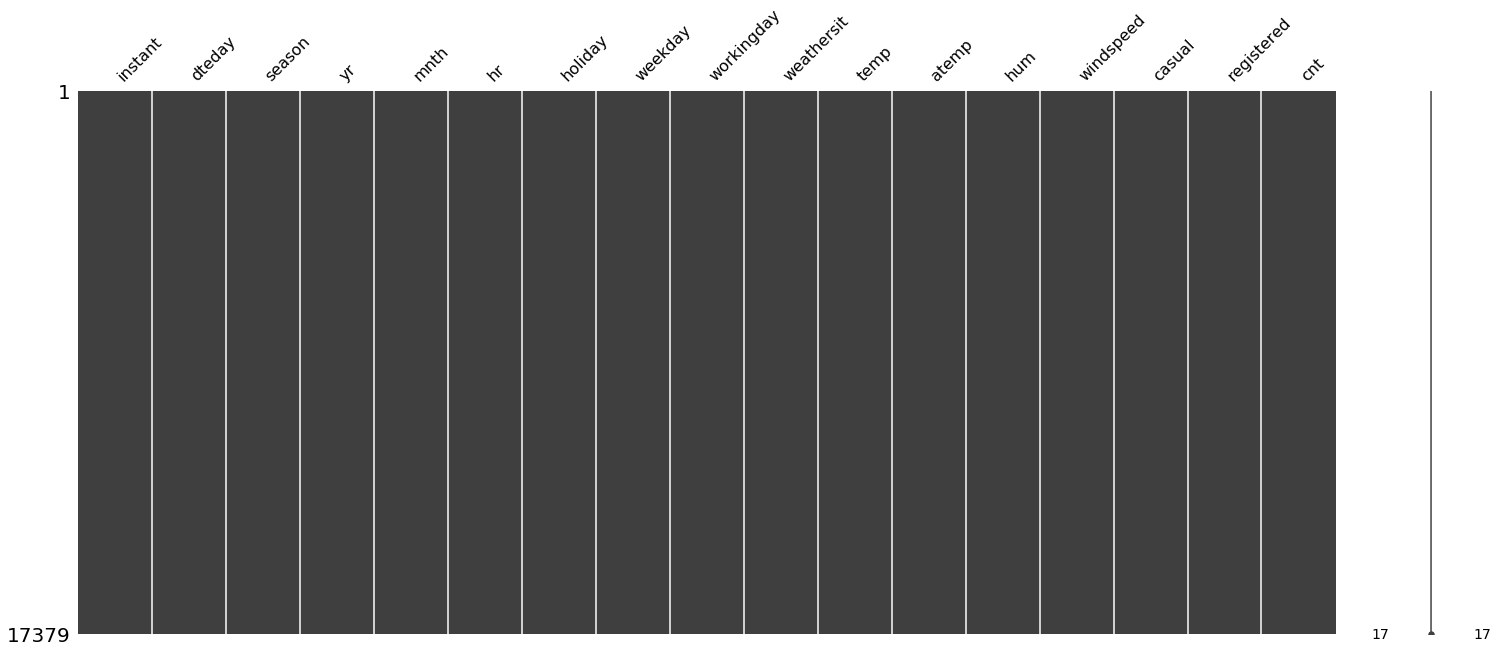

In [7]:
# 결측치값 확인하기
import missingno as msno 
msno.matrix(bike_df)
# 결측치가 없다. 따로 전처리(결측치값에 대한) 가 필요없겠구나... 

In [8]:
# 데이터의 타입
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [9]:
# 날짜 == object 
bike_df['dteday']

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
17374    2012-12-31
17375    2012-12-31
17376    2012-12-31
17377    2012-12-31
17378    2012-12-31
Name: dteday, Length: 17379, dtype: object

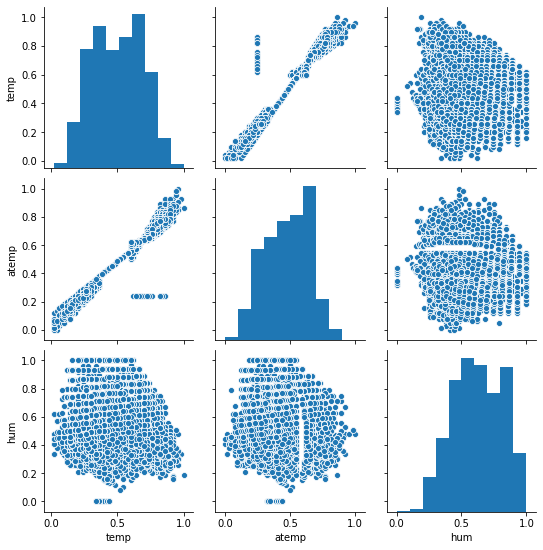

In [10]:
# 데이터의 시각화 
# seaborn as sns
# pairplot: 변수간의 관계를 히스토그램과 산포도로 보여주는것 
sns.pairplot(bike_df[['temp', 'atemp', 'hum']])
# 데이터가 고르게 분포한다. 

In [11]:
bike_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [12]:
# instant , dteday 삭제 
# 단순기록정보, 시간의 흐름은 아직은 넣을 수가 없기때문 
bike_df = bike_df.drop(['instant', 'dteday'], axis=1 )

## stats_model 에서 p-value의미 

- P-value : 각 `독립변수`가 얼마나 `종속변수`에 영향을 미치는지 나타낸다. 정확히 말하면, 회귀분석에서 수행하는 테스트에서 P값은 독립변수의 계수가 0일 확률을 나타냅니다. 즉, P값이 `작을수록` 해당 독립변수가 모델에서 의미를 가지며, P값이 `높을수록` 해당 독립변수는 종속 변수에 영향을 끼치지 못하게 됩니다. 일반적으로, P값이 0.05 미만일 때 통계적으로 유의하다고 합니다. 

- 따라서,stats_model linear_regression 결과 0.05 보다 큰 것은 유의미 하지 않으므로 삭제
- _sklearn 에서는 p-value 확인이 안되므로 stats_model을 사용함._

In [13]:
## 회귀분석을 하기 위해서 p-value 값을 확인 
## p-value가 0.05 보다 큰 것은 유의미 하지 않기 때문에 삭제가 가능
## 모델을 만들때 X 가 너무 많으면 모델성능이 저하된다. 
## X를 다 사용하지 않고 골라서 사용해야된다.
## feature selection

feature_names = bike_df.columns[:-3]
target_names = 'cnt'

# 독립변수 X 설정 
features = bike_df[feature_names]

# 종속변수 y 설정
target = bike_df[target_names]

# bias 추가  == states_model 을 통해 p-value 확인 할 것인데 
# 정보를 담을 통? 이 필요 
features_1 = sm.add_constant(features, has_constant='add')

# 모델 만들기 # sm == stats_model 
multi_model = sm.OLS(target, features_1.astype(float))
fitted_multi_model= multi_model.fit() # 학습

In [14]:
# 결과 보기
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     920.8
Date:                Tue, 11 Aug 2020   Prob (F-statistic):               0.00
Time:                        02:08:08   Log-Likelihood:            -1.1076e+05
No. Observations:               17379   AIC:                         2.216e+05
Df Residuals:                   17366   BIC:                         2.217e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.7573      7.057     -3.650      0.000     -39.590     -11.925
season        19.8993      1.819     10.941      0.000      16.334      23.464
yr            81.0872      2.164     37.463      0.000      76.845      85.330
mnth          -0.0086      0.567     -0.015      0.988      -1.120       1.103
hr             7.6706      0.165     46.513      0.000       7.347       7.994
holiday      -21.8792      6.694     -3.268      0.001     -35.001      -8.758
weekday        1.8784      0.541      3.474      0.001       0.819       2.938
workingday     3.9392      2.396      1.644      0.100      -0.756       8.635
weathersit    -3.4321      1.905     -1.802      0.072      -7.165       0.301
temp          78.1498     36.957      2.115      0.034       5.710     150.590
atemp        233.1571     41.517      5.616      0.000     151.779     314.535
hum         -198.1847      6.889    -28.770      0.000    -211.687    -184.682
windspeed     41.5652      9.628      4.317      0.000      22.692      60.438
==============================================================================
Omnibus:                     3417.855   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6659.872
Skew:                           1.198   Prob(JB):                         0.00
Kurtosis:                       4.859   Cond. No.                         787.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# 'mnth', workingday 삭제 since, p-value 가 크므로 
bike_df = bike_df.drop(['mnth','workingday'], axis=1 )

In [ ]:
# casual registered 필요가 없으므로 삭제 
bike_df = bike_df.drop(['casual', 'registered'],axis=1)

In [ ]:
bike_df.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [ ]:
bike_df.head(3)

,season,yr,hr,holiday,weekday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.22,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.22,0.2727,0.80,0.0,32


## 범주형 데이터를 수치형 데이터로 바꾸기

- ex1) season: 1 이 숫자 1이 아니라 봄이라는 의미를 갖도록 하자 
- ex2) weathersit: 1이 맑거나 조금 흐림

## 여기서 잠깐! 범주형을 이산형으로 바꾸는 3가지 방법 

- apply.map()
- sklearn preprocessing
- `One-hot encoding (== get_dummy)` 


**One hot Vector**

아래 그림과 같은 단어 집합 (여기서는 자연어로 쓰여져 있는 범주 또는 카테고리 이름)을 One-hot encoding으로 기계가 이해할 수 있는 언어로 만들기 위해 하나의 Feature 값을 나타내는 Vector로 만든 것.

여기서 해당 Vector는 오로지 0과 1로만 표현이 된다. 
주로 0은 '없음' '해당하지 않음' 'False' 등의 상태를 나타내며, 1은 '있음' '해당함' 'True' 등의 상태를 나타낸다. 

<img src = "https://miro.medium.com/max/2736/0*T5jaa2othYfXZX9W.">

one-hot encoding 방법 
```python 
# one-hot encoding 
import pandas as pd 
make_dummy = pd.get_dummies()

```



---save_point

In [ ]:
# copy 하는 이유는 원래의 데이터를 지키기 위해 
# feature selection 끝났는데 다시하기 싫어서... 
bike_df_dummy = bike_df.copy()

In [ ]:
# one-hot encoding 할 컬럼 
category_list = ['season','hr','weekday','weathersit']

In [ ]:
# one-hot encoding 
import pandas as pd 
# for 문을 사용하여 하나씩 바꾸기 
for category in  category_list:
    make_dummy = pd.get_dummies(bike_df_dummy[category],
                               prefix= category,
                               drop_first=False) # 컬럼 하나 지우기 
    # 변환 결과와 원래 데이터 결합 
    bike_df_dummy = pd.concat([bike_df_dummy,make_dummy],axis=1)

In [ ]:
bike_df_dummy.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2', 'season_3',
       'season_4', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
       'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14',
       'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4'],
      dtype='object')

In [ ]:
# 전처리 끝 

## 모델학습 

1. 모델1: one_hot encoding 미실시 

2. 모델2: one_hot encoding 실시

In [ ]:
# X, y 설정 
X_1 = bike_df.drop('cnt',axis=1)
y_1 = bike_df['cnt']

X_2 = bike_df_dummy.drop('cnt',axis=1)
y_2 = bike_df_dummy['cnt']

In [ ]:
# train_test split
from sklearn.model_selection import train_test_split
# one_hot encoding 미실시 
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=42)

# one_hot encoding 실시 
X_train_one, X_test_one, y_train_one, y_test_one = \
train_test_split(X_2, y_2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression

# 모델(1, 2) 정의 
model_1 = LinearRegression()
model_2 = LinearRegression()

# 모델을 학습 fitting 
model_1.fit(X_train, y_train)
model_2.fit(X_train_one, y_train_one)

# 결과 예측하기
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test_one)

In [ ]:
# 회귀(regression) 평가 지표 r2, mse, mae  
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
import numpy as np
print('Onehotencoding 미실시')
print(f'r2_score: { r2_score(y_test, y_pred_1)}')
print(f'MAE_score:{mean_absolute_error(y_test, y_pred_1)}') 
print(f'MSE_score:{mean_squared_error(y_test, y_pred_1)}')  
print(f'RMSE_score:{np.sqrt(mean_squared_error(y_test, y_pred_1))}') 
print('-'*50)
print('Onehotencoding 실시')
print(f'r2_score: { r2_score(y_test_one, y_pred_2)}')
print(f'MAE_score:{mean_absolute_error(y_test_one, y_pred_2)}') 
print(f'MSE_score:{mean_squared_error(y_test_one, y_pred_2)}')  
print(f'RMSE_score:{np.sqrt(mean_squared_error(y_test_one, y_pred_2))}') 
# 0<= r2 score <=1  1에 가까울수록 좋은것 
# MAE, MSE, RMSE 0에 가까울수록 좋은 것 
# 원핫 인코딩이 필수다 . 

Onehotencoding 미실시
r2_score: 0.3830049674171372
MAE_score:105.42740035363444
MSE_score:19841.518503968007
RMSE_score:140.8599251170041
--------------------------------------------------
Onehotencoding 실시
r2_score: 0.6801989341787025
MAE_score:74.47645192031071
MSE_score:10284.262319777723
RMSE_score:101.41135202617961
